In [ ]:
import sys
from PIL import Image
import matplotlib.pyplot as plt

import torch
torch.set_float32_matmul_precision("high")
from transformers import CLIPProcessor, CLIPModel

import shapiq 

import src

### load model

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to('cuda')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### load data

In [ ]:
input_text = "black dog next to a yellow hydrant"
input_image = Image.open("assets/dog_and_hydrant.png")

### define game

In [ ]:
game = src.game_huggingface.VisionLanguageGame(
    model=model,
    processor=processor,
    input_image=input_image,
    input_text=input_text,
    batch_size=64
)
n_players_image = game.n_players_image
n_players_text = game.n_players_text

### define approximator

In [ ]:
fixlip = src.fixlip.FIxLIP(
    n_players_image=n_players_image,
    n_players_text=n_players_text, 
    max_order=2,
    p=0.5,
    mode="banzhaf",
    random_state=0
)

### compute explanation

In [ ]:
src.utils.set_seed(0)
interaction_values = fixlip.approximate_crossmodal(game, budget=2**20)

### save explanation

In [ ]:
interaction_values.save("results/dog_and_hydrant_fixlip.pkl")

### visualize explanation

In [ ]:
interaction_values = shapiq.InteractionValues.load("results/dog_and_hydrant_fixlip.pkl")
print(interaction_values)

InteractionValues(
    index=FWBII, max_order=2, min_order=0, estimated=True, estimation_budget=2096976,
    n_players=57, baseline_value=-1.3254055855967117,
    Top 10 interactions:
        (54,): 1.9207237911813395
        (33, 55): 1.5218130201465327
        (55, 56): 1.5182699770717867
        (28, 50): 1.284221860604479
        (29, 50): 1.2656427565957886
        (36, 50): 1.2387052318271383
        (): -1.3254055855967117
        (56,): -2.0142689026871374
        (50,): -4.10809054757224
        (55,): -5.684341077817515
)


In [6]:
def denormalize(img, mean, std):
    return img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
image_mean = (0.48145466, 0.4578275, 0.40821073)
image_std = (0.26862954, 0.26130258, 0.27577711)

In [7]:
text_tokens = game.inputs.tokens()
text_tokens = text_tokens[1:-1]
text_tokens = [token.replace('</w>', '') for token in text_tokens]
assert len(text_tokens) == game.n_players_text
players_text = list(range(game.n_players_image, game.n_players))
assert game.n_players == interaction_values.n_players == max(players_text) + 1
input_image_processed = game.inputs['pixel_values'].squeeze(0)
input_image_denormalized = src.utils.denormalize(
    input_image_processed, 
    game.processor.image_processor.image_mean, 
    game.processor.image_processor.image_std
).permute(1, 2, 0).numpy()

### FIxLIP

<string>:12: UserWarning: Index FWBII is not a valid index as defined in {'STII', 'BV', 'JointSV', 'SGV', 'ELC', 'k-SII', 'Moebius', 'SII', 'IGV', 'FBII', 'kADD-SHAP', 'CHGV', 'BII', 'SV', 'EC', 'Co-Moebius', 'BGV', 'FSII', 'CHII', 'EGV'}. This might lead to unexpected behavior.


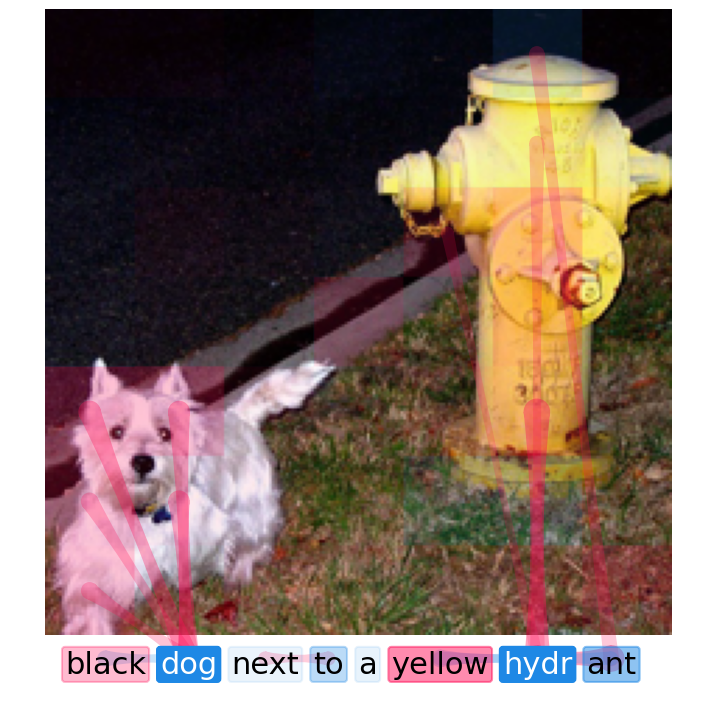

In [ ]:
src.plot.plot_image_and_text_together(
    img=input_image_denormalized,
    text=text_tokens,
    image_players=list(range(n_players_image)),
    iv=interaction_values,
    plot_interactions=True,
    top_k=14,
    normalize_jointly=True,
    figsize=(7, 7),
    fontsize=22,
    margin=0.3,
    color_text=True,
    plot_heatmap=True,
    show=False,
    max_value=4
)
plt.tight_layout(pad=0.15)
# plt.savefig("dog_and_hydrant_fixlip.pdf")

### GAME

In [ ]:
iv_game = shapiq.InteractionValues.load("results/dog_and_hydrant_game.pkl")
print(iv_game)

InteractionValues(
    index=, max_order=1, min_order=0, estimated=True, estimation_budget=None,
    n_players=57, baseline_value=0,
    Top 10 interactions:
        (56,): 0.1417236328125
        (12,): 0.02716064453125
        (18,): 0.02264404296875
        (26,): 0.016082763671875
        (19,): 0.012054443359375
        (40,): 0.00997161865234375
        (33,): 0.00981903076171875
        (20,): 0.00688934326171875
        (55,): 0.0054931640625
        (5,): 0.005481719970703125
)


<string>:12: UserWarning: Index  is not a valid index as defined in {'STII', 'BV', 'JointSV', 'SGV', 'ELC', 'k-SII', 'Moebius', 'SII', 'IGV', 'FBII', 'kADD-SHAP', 'CHGV', 'BII', 'SV', 'EC', 'Co-Moebius', 'BGV', 'FSII', 'CHII', 'EGV'}. This might lead to unexpected behavior.


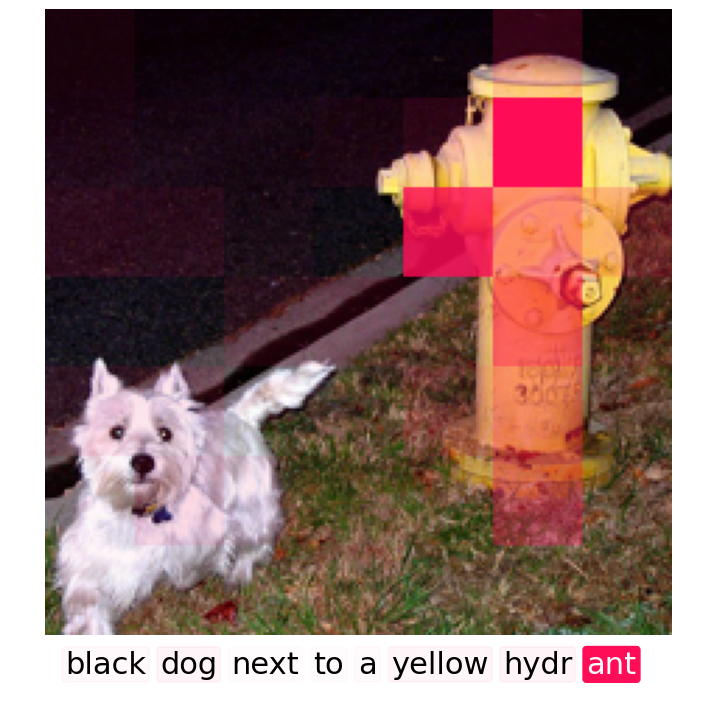

In [ ]:
src.plot.plot_image_and_text_together(
    img=input_image_denormalized,
    text=text_tokens,
    image_players=list(range(n_players_image)),
    iv=iv_game,
    plot_interactions=False,
    normalize_jointly=False,
    figsize=(7, 7),
    fontsize=22,
    margin=0.3,
    color_text=True,
    plot_heatmap=True,
    show=False,
)
plt.tight_layout(pad=0.15)
# plt.savefig("dog_and_hydrant_game.pdf")

### Grad-ECLIP

In [ ]:
iv_gradeclip = shapiq.InteractionValues.load("results/dog_and_hydrant_gradeclip.pkl")
print(iv_gradeclip)

InteractionValues(
    index=, max_order=1, min_order=0, estimated=True, estimation_budget=None,
    n_players=57, baseline_value=0,
    Top 10 interactions:
        (18,): 0.299560546875
        (12,): 0.255126953125
        (20,): 0.243408203125
        (56,): 0.212890625
        (11,): 0.1727294921875
        (40,): 0.155517578125
        (33,): 0.1522216796875
        (50,): 0.1451416015625
        (19,): 0.138671875
        (36,): 0.1378173828125
)


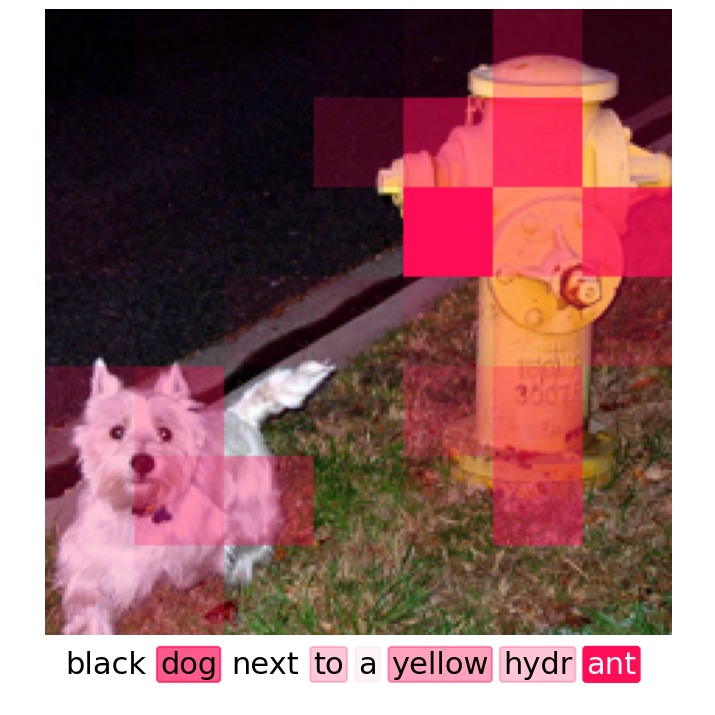

In [ ]:
src.plot.plot_image_and_text_together(
    img=input_image_denormalized,
    text=text_tokens,
    image_players=list(range(n_players_image)),
    iv=iv_gradeclip,
    plot_interactions=False,
    normalize_jointly=False,
    figsize=(7, 7),
    fontsize=22,
    margin=0.3,
    color_text=True,
    plot_heatmap=True,
    show=False,
)
plt.tight_layout(pad=0.15)
# plt.savefig("dog_and_hydrant_gradeclip.pdf")

### exCLIP

In [ ]:
iv_exclip = shapiq.InteractionValues.load("results/dog_and_hydrant_exclip.pkl")
print(iv_exclip)

InteractionValues(
    index=xclip, max_order=2, min_order=0, estimated=True, estimation_budget=None,
    n_players=57, baseline_value=0,
    Top 10 interactions:
        (18, 56): 0.0062236059457063675
        (20, 56): 0.005851599387824535
        (12, 56): 0.005055509507656097
        (33, 56): 0.0035493001341819763
        (11, 56): 0.0033396072685718536
        (40, 56): 0.0032137271482497454
        (32, 56): 0.0023629264906048775
        (29, 56): -0.0022027851082384586
        (28, 56): -0.002554086036980152
        (30, 56): -0.0028323226142674685
)


<string>:12: UserWarning: Index xclip is not a valid index as defined in {'STII', 'BV', 'JointSV', 'SGV', 'ELC', 'k-SII', 'Moebius', 'SII', 'IGV', 'FBII', 'kADD-SHAP', 'CHGV', 'BII', 'SV', 'EC', 'Co-Moebius', 'BGV', 'FSII', 'CHII', 'EGV'}. This might lead to unexpected behavior.


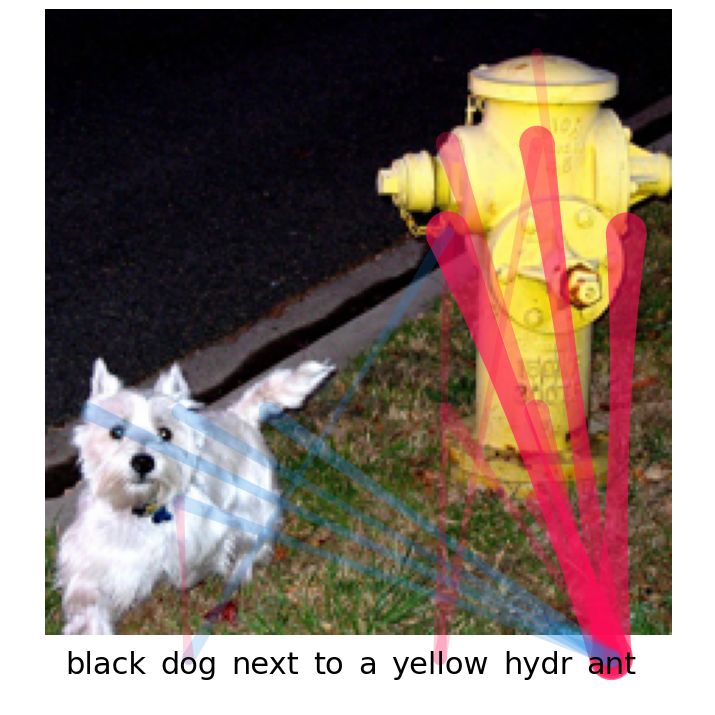

In [ ]:
src.plot.plot_image_and_text_together(
    img=input_image_denormalized,
    text=text_tokens,
    image_players=list(range(n_players_image)),
    iv=iv_exclip,
    plot_interactions=True,
    top_k=16,
    normalize_jointly=True,
    figsize=(7, 7),
    fontsize=22,
    margin=0.3,
    color_text=True,
    plot_heatmap=True,
    max_value=0.01,
    show=False,
)
plt.tight_layout(pad=0.15)
# plt.savefig("dog_and_hydrant_exclip.pdf")